# Histopathologic Cancer Detection with CNN Models

## Exploratory Data Analysis

Cancerous cells have at least one tumour cells in the center 32x32 region.

In [17]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pylab as plt
import seaborn as sns

from tifffile import imread

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import os
#!pip install visualkeras
#import visualkeras
from skimage import draw

In [18]:
#Loading training directory
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.tif'
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


0    130908
1     89117
Name: label, dtype: int64

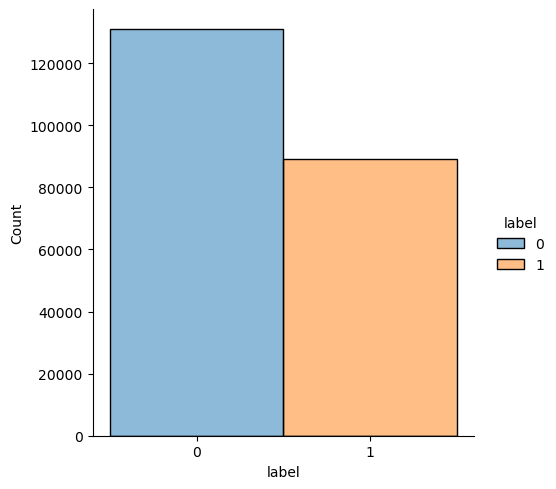

In [19]:
#Checking the labels, how many are negative and how many are positive 
sns.displot(data=train_df, x='label', hue='label')
train_df['label'].value_counts()

In [ ]:
#Loading the data with the images 

batch_size, im_size = 256, (96,96)

generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = '/kaggle/input/histopathologic-cancer-detection/train',
    subset = 'training',
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

val_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = '/kaggle/input/histopathologic-cancer-detection/train',
    subset = "validation",
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

In [20]:
#PLotting the training graph function with accuracy and loss history 

def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss","Validation Loss"])
    #plt.suptitle("Model Evaluation")
    plt.tight_layout()
    plt.show()

## VGG16 Backbone

In [21]:
base_model = tf.keras.applications.VGG16(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

58889256/58889256 [==============================] - 0s 0us/step


![vgg16.png](attachment:66b20712-27f9-437e-ad9a-e3c97b55a636.png)

In [22]:
#Original Model
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg16_backbone')
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 4608)             18432     
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                73744     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                    

In [ ]:
#Model 1
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid') 
], name='vgg16_backbone')
model_vgg16.summary()

In [ ]:
#Model 2
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    BatchNormalization()
], name='vgg16_backbone')
model_vgg16.summary()

## Training the model

In [23]:
#Compiling code and declaring optimizer 
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
model_vgg16.summary()

In [ ]:
%%time 
# Training 
hist = model_vgg16.fit(train_data, epochs = 9, validation_data = val_data, verbose=1)

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

## VGG19 Backbone

In [24]:
base_model = tf.keras.applications.VGG19(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

80134624/80134624 [==============================] - 0s 0us/step


![vgg19.png](attachment:c7fa0523-b440-4291-904b-08f02c608c1f.png)

In [26]:
np.random.seed(1)
tf.random.set_seed(1)
#Model 2
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    BatchNormalization()
], name='vgg19_backbone')

model_vgg19.summary()

Model: "vgg19_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 4608)             18432     
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 16)                73744     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                    

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg19_backbone')

model_vgg19.summary()

In [ ]:
#Model 1
np.random.seed(1)
tf.random.set_seed(1)
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid') 
], name='vgg19_backbone')
model_vgg19.summary()

In [27]:
#Compiling model and declaring optimizer
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
base_model.trainable = True
model_vgg19.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
%%time 
# Training
hist = model_vgg19.fit(train_data, epochs = 7, validation_data = val_data, verbose=1)

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

## ResNet50 Backbone

In [28]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

94765736/94765736 [==============================] - 2s 0us/step


![resnet50.png](attachment:c6d2a377-c2dc-4dab-8dcf-283cbe6c5e67.png)

In [29]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet50_backbone')

model_resnet50.summary()

Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 batch_normalization_7 (Batc  (None, 18432)            73728     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 16)                294928    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                170       
                                                 

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'resnet50_backbone')

model_resnet50.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='resnet50_backbone')

model_resnet50.summary()

## Training

In [30]:
#Compiling model and declaring optimizer 
base_model.trainable = True
#opt = tf.keras.optimizers.SGD(0.0003)
opt = tf.keras.optimizers.Adam(0.001)
model_resnet50.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
%%time 
#remnoved batch normalization
#Training
hist = model_resnet50.fit(train_data, validation_data=val_data, epochs=8, verbose=1)

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

## Resnet 101

In [31]:
base_model = tf.keras.applications.ResNet101(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

171446536/171446536 [==============================] - 3s 0us/step


In [32]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet101_backbone')

model_resnet101.summary()

Model: "resnet101_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 3, 3, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 batch_normalization_10 (Bat  (None, 18432)            73728     
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 16)                294928    
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                170       
                                                

In [33]:
# Compiling the model and declaring the optimizer 
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
model_resnet101.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'resnet101_backbone')

model_resnet101.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='resnet101_backbone')

model_resnet101.summary()

In [ ]:
%%time 
# Training
hist = model_resnet101.fit(train_data, validation_data=val_data, epochs=7, verbose=1)

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

## MobileNetV2

In [34]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

In [35]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'mobilenetv2_backbone')

model_mobilenetv2.summary()

Model: "mobilenetv2_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 11520)             0         
                                                                 
 batch_normalization_13 (Bat  (None, 11520)            46080     
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 16)                184336    
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 batch_normalization_14 (Bat  (None, 16)      

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='mobilenetv2_backbone')

model_mobilenetv2.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'mobilnetv2_backbone')

model_mobilenetv2.summary()

In [36]:
#Declaring optimizer and compiling the model 
base_model.trainable = True
opt = tf.keras.optimizers.SGD(0.001)
#opt = tf.keras.optimizers.Adam(0.001)
model_mobilenetv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

In [ ]:
# Trainining
hist = model_mobilenetv2.fit(train_data, validation_data=val_data, epochs=7, verbose=1)

## MobileNet

In [ ]:
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'mobilnet_backbone')

model_mobilenet.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='mobilenet_backbone')

model_mobilenet.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'mobilenet_backbone')

model_mobilenet.summary()

In [ ]:
#Declaring optimizer and compiling models 
base_model.trainable = True
opt = tf.keras.optimizers.SGD(0.001)
#opt = tf.keras.optimizers.Adam(0.001)
model_mobilenet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

In [ ]:
# Training
hist = model_mobilenet.fit(train_data, validation_data=val_data, epochs=7, verbose=1)